In [5]:
import astropy.io.fits as fits
import numpy as np
from scipy.integrate import quad
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import halomod as hm
import hmf
import treecorr

In [6]:
import DarkVerse as dv


In [7]:

home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')



# Catalog
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  
t= Table.read(fits_file_path)
masked_file_path = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  
t3= Table.read(masked_file_path)

# Join in one table

t=join(t,t3,keys='id') 
t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')


# Load Randoms
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
t2 = Table.read(fits_random)
randoms = t2  # Random catalog

# Define Correlation Function Configuration
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}



z_min=0.6
z_max=0.7
SM_min=10.5
SM_max=11

# Select Subsample
subsample = dv.Subsample(catalog=t, randoms=randoms, z_min=z_min, z_max=z_max, SM_min=SM_min, SM_max=SM_max, config=config)

# Get Results
results = subsample.get_results()

print(f"Power Law Parameters (A, gamma): {results['power_law_params']}")
print()
#print(f"w_theta: {results['w_theta']}")
#print(f"DD counts: {results['dd_counts']}")
#print(f"DR counts: {results['dr_counts']}")
#print(f"RR counts: {results['rr_counts']}")


The following patch numbers have no objects: {39}
This may be a problem depending on your use case.
The following patch numbers have no objects: {38}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.
The following patch numbers have no objects: {37}
This may be a problem depending on your use case.
Power Law Parameters (A, gamma): [7.50411352e-04 1.39778761e+00]



Errors on w_theta: [0.7381727  0.6708045  0.60988425 0.55458237 0.50448466 0.45900213
 0.41768089 0.38005316 0.34586629 0.31482948 0.28668094 0.26117466
 0.2380155  0.21701663 0.19797178 0.18070867 0.1650624  0.15088913
 0.13801337 0.1262363  0.11534415 0.10526647 0.09601755 0.08754856
 0.07982595 0.07278731 0.06641237 0.06058648 0.05531316 0.05051235
 0.04616389 0.04217175 0.03851604 0.03522045 0.03224324 0.02953547
 0.02707731 0.0248122  0.02273159 0.02065878 0.01855454 0.01689706
 0.01561456 0.01442661 0.01335663 0.01243886 0.0115057  0.01053951
 0.00976102 0.00913483 0.00856636 0.00791295 0.00736563 0.00686849
 0.00637549 0.00597371 0.00562674 0.00540405 0.00528855 0.00536207
 0.00561113 0.00608677 0.00723364 0.01005838]


/tmp/ipykernel_857763/2901281716.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


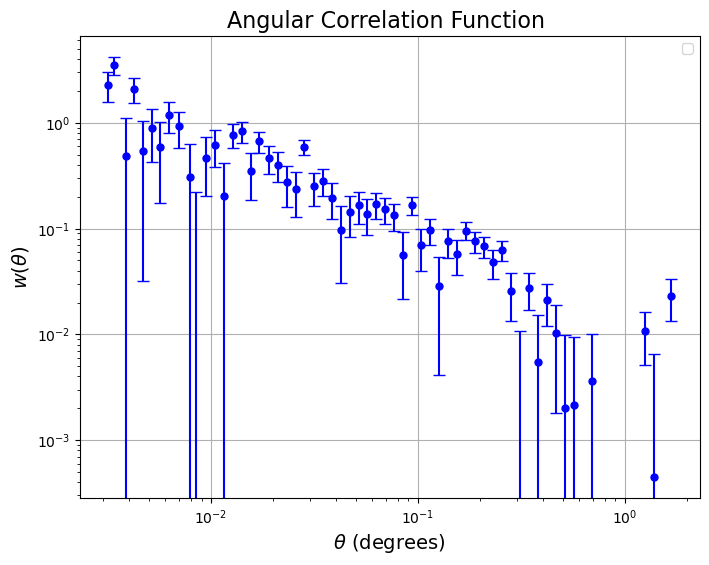

In [8]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)


plt.figure(figsize=(8, 6))
plt.errorbar(theta_values, w_theta_values, yerr= w_theta_errors, fmt='o', color='blue', capsize=4, markersize=5)

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function ', fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
plt.show()


### ^these errors are way too big wtf is going on??

In [9]:
gg = subsample.compute_gg()  



In [10]:


# Compute correlation functions
theta, xi_g, xi_m = subsample.compute_gg()

results = subsample.get_results()

#print("Galaxy-Galaxy Angular Correlation:", results['xi_g'])
#print("Matter-Matter Angular Correlation:", results['xi_m'])


Errors on w_theta: [0.7381727  0.6708045  0.60988425 0.55458237 0.50448466 0.45900213
 0.41768089 0.38005316 0.34586629 0.31482948 0.28668094 0.26117466
 0.2380155  0.21701663 0.19797178 0.18070867 0.1650624  0.15088913
 0.13801337 0.1262363  0.11534415 0.10526647 0.09601755 0.08754856
 0.07982595 0.07278731 0.06641237 0.06058648 0.05531316 0.05051235
 0.04616389 0.04217175 0.03851604 0.03522045 0.03224324 0.02953547
 0.02707731 0.0248122  0.02273159 0.02065878 0.01855454 0.01689706
 0.01561456 0.01442661 0.01335663 0.01243886 0.0115057  0.01053951
 0.00976102 0.00913483 0.00856636 0.00791295 0.00736563 0.00686849
 0.00637549 0.00597371 0.00562674 0.00540405 0.00528855 0.00536207
 0.00561113 0.00608677 0.00723364 0.01005838]


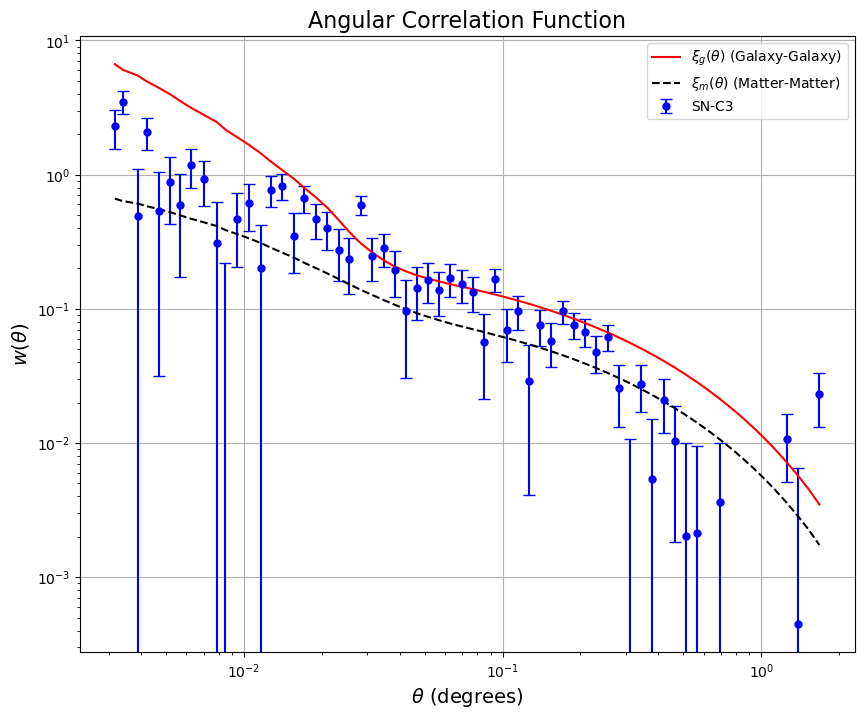

In [11]:

theta_values = results['theta']
w_theta_values = results['w_theta']
var_w_theta_values = results['var_w_theta']
xi_g_values = results['xi_g']
xi_m_values = results['xi_m']

# Compute errors (standard deviation)
w_theta_errors = np.sqrt(var_w_theta_values)

print("Errors on w_theta:", w_theta_errors)

plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


In [12]:


bias_estimator = dv.BiasEstimator(
    xi_g=results['xi_g'],
    xi_m=results['xi_m'],
    w_theta_list=[results['w_theta']], 
    w_theta_error_list=[results['var_w_theta']], 
    sum_rr_list=[results['rr_counts']], 
    mask = (theta_values >= 0.1) & (theta_values <= 0.4)
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.3760268473463846]
Bias errors: [0.000602769498311954]


In [13]:
xi_m_values = np.array(results['xi_m'])  # Matter-matter correlation function
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction

# Compute the model: xi_m * b^2 - IC
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

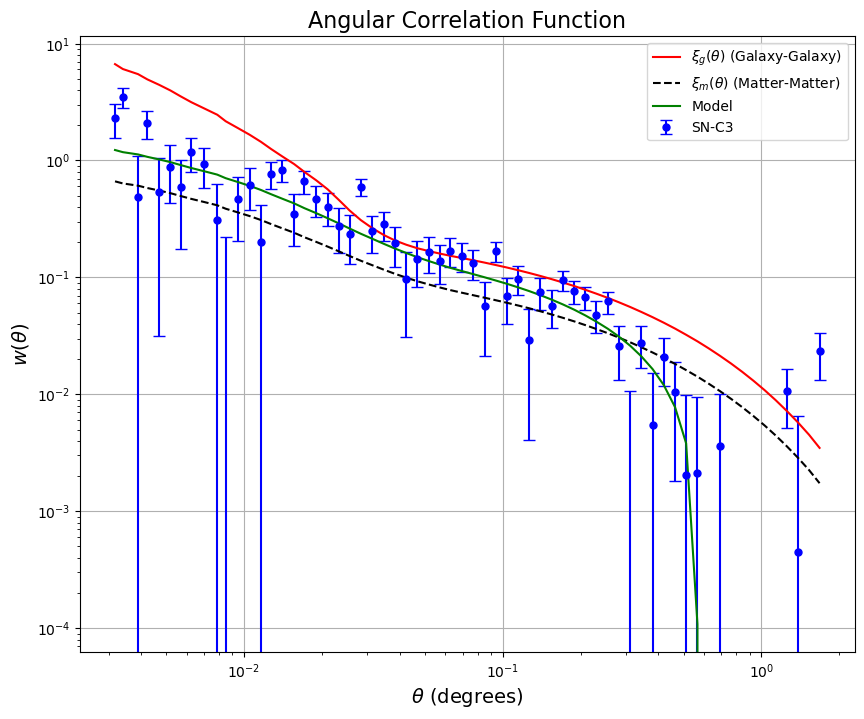

In [14]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='blue', capsize=4, markersize=5, label='SN-C3')

# Plot galaxy and matter correlation functions
plt.plot(theta_values, xi_g_values, label=r'$\xi_{g}(\theta)$ (Galaxy-Galaxy)', linestyle='-', color='red')
plt.plot(theta_values, xi_m_values, label=r'$\xi_{m}(\theta)$ (Matter-Matter)', linestyle='dashed', color='black')

plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

# Labels and title
plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [15]:

print("\n--- Subsample Information ---")
print(f"Redshift range: {subsample.z_min} ≤ z ≤ {subsample.z_max}")
print(f"Stellar Mass range: {subsample.SM_min} ≤ SM ≤ {subsample.SM_max}")
print(f"Number of galaxies in subsample: {len(subsample.filtered_catalog)}")



--- Subsample Information ---
Redshift range: 0.6 ≤ z ≤ 0.7
Stellar Mass range: 10.5 ≤ SM ≤ 11
Number of galaxies in subsample: 927


In [16]:


print("\n--- Bootstrap Error Estimations ---")
print("Variance from bootstrap:", results['var_w_theta_bootstrap'])
print("Covariance Matrix:\n", results['covariance_w_theta_bootstrap'])



--- Bootstrap Error Estimations ---
Variance from bootstrap: [5.54274758e+00 4.42363602e+00 1.11837722e+00 2.18804882e+00
 1.04819752e+00 1.43388053e+00 8.50450809e-01 1.11126176e+00
 1.07393106e+00 5.17525688e-01 2.64391113e-01 3.61544325e-01
 2.62235801e-01 1.60710273e-01 2.41686741e-01 2.53515277e-01
 1.13416585e-01 9.94406245e-02 7.76246624e-02 8.88786058e-02
 5.38985859e-02 4.76254786e-02 5.65798251e-02 3.53534325e-02
 2.70388450e-02 2.02785702e-02 1.90734600e-02 1.43630872e-02
 1.08049098e-02 1.23005264e-02 9.35314884e-03 7.90631054e-03
 6.36069512e-03 4.24788771e-03 4.11976661e-03 3.44370904e-03
 4.20664663e-03 1.87515596e-03 2.21634221e-03 2.20171678e-03
 1.76551134e-03 1.23103594e-03 1.26888013e-03 7.94383784e-04
 9.12268396e-04 7.20572220e-04 6.72689016e-04 7.43976990e-04
 4.26580037e-04 4.27053262e-04 3.11624911e-04 2.65837958e-04
 3.17607547e-04 2.47720376e-04 2.64295016e-04 1.43436435e-04
 2.18782254e-04 1.86395882e-04 2.31013837e-04 2.01742363e-04
 1.82088565e-04 1.50378

In [17]:
w_theta_errors_bootstrap= np.sqrt(results['var_w_theta_bootstrap'])

In [18]:
"""bootstrap_w_theta = []

for i in range(100):  
    sample_indices = np.random.choice(len(subsample.filtered_catalog), size=len(subsample.filtered_catalog), replace=True)
    bs_galaxies = subsample.filtered_catalog[sample_indices]
    
    bs_corr = dv.CorrelationFunction(bs_galaxies, randoms, config)
    bs_corr.process()
    w_theta_bs, _, _ ,_, _, _ = bs_corr.calculate_w_theta()
    
    bootstrap_w_theta.append(w_theta_bs)

variance_bootstrap = np.var(bootstrap_w_theta, axis=0)
covariance = np.cov(bootstrap_w_theta)

std_dev= np.std(bootstrap_w_theta, axis=0) #woks better with axis=0 than axis=1 (errors are very big in the latter case)
print(std_dev)
std_dev.shape

print(np.sqrt(variance_bootstrap))

"""

'bootstrap_w_theta = []\n\nfor i in range(100):  \n    sample_indices = np.random.choice(len(subsample.filtered_catalog), size=len(subsample.filtered_catalog), replace=True)\n    bs_galaxies = subsample.filtered_catalog[sample_indices]\n    \n    bs_corr = dv.CorrelationFunction(bs_galaxies, randoms, config)\n    bs_corr.process()\n    w_theta_bs, _, _ ,_, _, _ = bs_corr.calculate_w_theta()\n    \n    bootstrap_w_theta.append(w_theta_bs)\n\nvariance_bootstrap = np.var(bootstrap_w_theta, axis=0)\ncovariance = np.cov(bootstrap_w_theta)\n\nstd_dev= np.std(bootstrap_w_theta, axis=0) #woks better with axis=0 than axis=1 (errors are very big in the latter case)\nprint(std_dev)\nstd_dev.shape\n\nprint(np.sqrt(variance_bootstrap))\n\n'

In [19]:

mask = (theta_values >= 0.1) & (theta_values <= 0.4)

xi_g = np.array(results['xi_g'])
xi_m = np.array(results['xi_m'])
w_theta = np.array(results['w_theta']) 
w_theta_errors_bootstrap = np.array(w_theta_errors_bootstrap) 


bias_estimator = dv.BiasEstimator(
    xi_g=xi_g,
    xi_m=xi_m,
    w_theta_list=[w_theta], 
    w_theta_error_list=[w_theta_errors],  # Bootstrap errors 
    sum_rr_list=[results['rr_counts']], 
    mask=mask  
)

bias_values, bias_errors = bias_estimator.estimate_bias()
print("Bias values:", bias_values)
print("Bias errors:", bias_errors)


Bias values: [1.3988354371442286]
Bias errors: [0.040451930087761635]


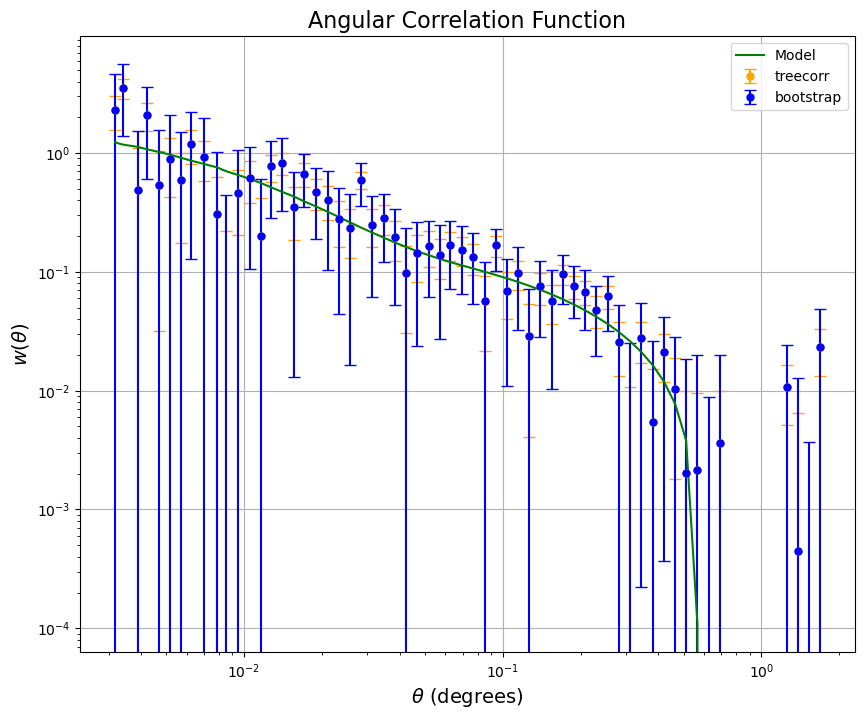

In [20]:
plt.figure(figsize=(10, 8))
plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors, fmt='o', 
             color='orange', capsize=4, markersize=5, label='treecorr ')  # Careful I changed in config 'var_method' to'shot', Poisson noise

plt.errorbar(theta_values, w_theta_values, yerr=w_theta_errors_bootstrap, fmt='o', color='blue', capsize=4, markersize=5, label='bootstrap')


plt.plot(theta_values, model_values, label=r'Model', color='g')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$\theta$ (degrees)', fontsize=14)
plt.ylabel(r'$ w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function', fontsize=16)

plt.legend()
plt.grid(True)
plt.show()

In [21]:
IC_values = np.array(bias_estimator.IC_list)  # Integral Constraint correction
model_values = xi_m_values * bias_values[0]**2 - IC_values[0]  # single subsample

N = len(subsample.filtered_catalog)  # Number of galaxies in the subsample

IC = bias_estimator.integral_constraint(xi_m, results['rr_counts'])

print("\nSubsample Information:")
print(f"  - Redshift range: {subsample.z_min} ≤ z < {subsample.z_max}")
print(f"  - Stellar mass range: {subsample.SM_min} ≤ SM < {subsample.SM_max}")
print(f"  - Number of galaxies: {N}")
print(f"  - Bias: {bias_values[0]:.3f} ± {bias_errors[0]:.3f}")



Subsample Information:
  - Redshift range: 0.6 ≤ z < 0.7
  - Stellar mass range: 10.5 ≤ SM < 11
  - Number of galaxies: 927
  - Bias: 1.399 ± 0.040


# Now I am trying all 4 fields

In [26]:
home_dir = os.path.expanduser('~')
thesis_path = os.path.join(home_dir, 'Master_Thesis', 'DATA')

fields = {
    "SN-X3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-X3_zm.fits",
        "masked": "SN-X3_masked_cat.fits",
        "randoms": "SN-X3_randoms_ugriz_trim_video.fits"
    },
    "SN-C3": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits",
        "masked": "SN-C3_masked_cat.fits",
        "randoms": "SN-C3_randoms_ugriz_trim_video.fits"
    },
    "SN-E2": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_SN-E2_zm.fits",
        "masked": "SN-E2_masked_cat.fits",
        "randoms": "SN-E2_randoms_ugriz_trim_video.fits"
     },
    "COSMOS": {
        "catalog": "Y3_deep_fields_DB_wKNN_cat_COSMOS_zm.fits",
        "masked": "COSMOS_masked_cat.fits",
        "randoms": "COSMOS_randoms_ugriz_trim_video.fits"
        
}}

z_min, z_max = 0.6, 0.7
SM_min, SM_max = 10.5, 11
config = {
    'min_sep': 0.003,
    'max_sep': 1.78,
    'bin_size': 0.1,
    'sep_units': 'degrees',
    'var_method': 'shot'   # if using the internal 'var_method': 'bootstrap' of treecrorr, but then it takes a long time to run
}

# Dictionary to store bias results for each field
bias_results = {}

for field, paths in fields.items():
    print(f"🔹 Processing field: {field}")

    # Load galaxy catalog & masked catalog
    catalog = Table.read(os.path.join(thesis_path, paths["catalog"]))
    masked = Table.read(os.path.join(thesis_path, paths["masked"]))

    # Join tables on ID
    catalog = join(catalog, masked, keys='id')
    catalog.rename_column('ra_1', 'ra')
    catalog.rename_column('dec_1', 'dec')

    # Load randoms
    randoms = Table.read(os.path.join(thesis_path, paths["randoms"]))

    # Select subsample
    subsample = dv.Subsample(catalog=catalog, randoms=randoms, 
                             z_min=z_min, z_max=z_max, 
                             SM_min=SM_min, SM_max=SM_max, 
                             config=config)

    results = subsample.get_results()

    theta_values = results['theta']
    theta_mask = (theta_values >= 0.1) & (theta_values <= 0.4)


    bias_estimator = dv.BiasEstimator(
        xi_g=results['xi_g'],
        xi_m=results['xi_m'],
        w_theta_list=[results['w_theta']], 
        w_theta_error_list=[np.sqrt(results['var_w_theta_bootstrap'])], 
        sum_rr_list=[results['rr_counts']], 
        mask=theta_mask
    )

    bias_values, bias_errors = bias_estimator.estimate_bias()
    
    bias_results[field] = {
        "bias_values": bias_values,
        "bias_errors": bias_errors
    }

    print(f"Bias for {field}: {bias_values}")
    print(f" Bias errors for {field}: {bias_errors}")
    print()


🔹 Processing field: SN-X3
The following patch numbers have no objects: {19}
This may be a problem depending on your use case.
The following patch numbers have no objects: {26}
This may be a problem depending on your use case.
The following patch numbers have no objects: {28}
This may be a problem depending on your use case.
The following patch numbers have no objects: {29}
This may be a problem depending on your use case.
The following patch numbers have no objects: {27}
This may be a problem depending on your use case.
Bias for SN-X3: [1.0073781097633754]
 Bias errors for SN-X3: [0.10789541466777298]

🔹 Processing field: SN-C3
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a problem depending on your use case.
The following patch numbers have no objects: {40}
This may be a problem depending on your use case.
The following patch numbers have no objects: {39}
This may be a 

In [27]:

print("\n Bias Comparison Across Fields:")
for field, bias_data in bias_results.items():
    print(f"{field}: Bias = {bias_data['bias_values']}, Errors = {bias_data['bias_errors']}")



 Bias Comparison Across Fields:
SN-X3: Bias = [1.0073781097633754], Errors = [0.10789541466777298]
SN-C3: Bias = [1.3960245171970733], Errors = [0.08600567119866215]
SN-E2: Bias = [1.150378016459535], Errors = [0.13176246448028406]
COSMOS: Bias = [1.1819539810652695], Errors = [0.09004803501897327]
